In [9]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

# Selenium の Chrome ドライバをヘッドレスモードで起動
options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# 対象の URL
url = 'https://www.realclearpolling.com/polls/approval/donald-trump/approval-rating'
driver.get(url)

# テーブルが存在するまで待機（最大10秒）
try:
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'table.w-full'))
    )
except Exception as e:
    print("テーブルが見つかりませんでした:", e)
    driver.quit()
    exit()

# 動的コンテンツが読み込まれるまでさらに待機（必要に応じて調整）
time.sleep(5)

# ページソースを取得し、BeautifulSoup で解析
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

# "w-full" クラスのテーブルをすべて取得し、2つ目をターゲットとする
tables = soup.find_all('table', class_='w-full')
if len(tables) < 2:
    driver.quit()
    raise ValueError("ターゲットとなる2つ目のテーブルが見つかりません。")
target_table = tables[1]

# ターゲットテーブル内の各行のデータを抽出（5列分）
rows_data = []
for tr in target_table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue  # ヘッダー行や空行はスキップ
    row = []
    for i, td in enumerate(tds):
        # セル内のテキストを取得（不要な空白は削除）
        text = td.get_text(separator=' ', strip=True)
        if ":: after" in text:
            text = text.split(":: after")[0].strip()
        # 5列目（インデックス 4）の場合、内部の <span> 要素から数値部分のみ取得
        if i == 4:
            span_elements = td.find_all('span')
            if span_elements:
                text = span_elements[-1].get_text(strip=True)
        row.append(text)
    # 行が6セル以上ある場合は先頭6セルのみ採用
    if len(row) >= 5:
        rows_data.append(row[:5])
    else:
        rows_data.append(row)

print("取得した行数:", len(rows_data))

# ここでは6列分のデータがあると仮定して、5つのカラム名を設定
columns = ["Pollster", "Date", "Approve", "Disapprove", "Spread"]

# ヘッダー行が含まれている場合は除外（ここでは rows_data[1:] を使用）
if len(rows_data) > 1:
    df = pd.DataFrame(rows_data[1:], columns=columns)
else:
    df = pd.DataFrame(rows_data, columns=columns)

print(df)

# ブラウザを閉じる
driver.quit()


取得した行数: 26
                      Pollster         Date  Approve Disapprove Spread
0            Rasmussen Reports  2/16 - 2/20  1500 LV         51     47
1             Economist/YouGov  2/16 - 2/18  1451 RV         50     47
2              Wash Post/Ipsos  2/13 - 2/18  2177 RV         48     51
3                      Emerson  2/15 - 2/17  1000 RV         48     42
4                Reuters/Ipsos  2/13 - 2/18   4145 A         44     51
5                   Quinnipiac  2/13 - 2/17  1039 RV         45     49
6                          CNN  2/13 - 2/17       RV         46     54
7                    SurveyUSA  2/13 - 2/16   2000 A         51     45
8             Economist/YouGov   2/9 - 2/11  1430 RV         47     49
9                       Gallup   2/3 - 2/16   1004 A         45     51
10  Trafalgar/InsiderAdvantage    2/7 - 2/9  1321 RV         54     45
11                    CBS News    2/5 - 2/7   2175 A         53     47
12            Economist/YouGov    2/2 - 2/4  1423 RV         48   

In [10]:
temp =[s.split(' - ') for _,s in enumerate(df['Date'].to_list())]
tempX = []

year1 = datetime.today().year
year2 = year1
month = str(datetime.today().month).zfill(2)

for i in range(len(temp)):
    PeriodStart = ''.join([s.zfill(2) for s in temp[i][0].split('/')])
    PeriodEnd = ''.join([s.zfill(2) for s in temp[i][1].split('/')])
    tempX.append([PeriodStart,PeriodEnd])
chk1 = 1
chk2 = 1
for i,s in enumerate(tempX):
    if i==0:
        if month<s[0][:2]:
            year1 += -1
        if month<s[1][:2]:
            year2 += -1        
    else:
        if (s[0][:2]>tempX[i-1][0][4:6])and(s[0][:2]=="12"):
            year1 += -1
        if s[1][:2]>tempX[i-1][1][4:6]and(s[1][:2]=="12"):
            year2 += -1

    tempX[i][0]=str(year1)+s[0]
    tempX[i][1]=str(year2)+s[1]
    tempX[i].append(tempX[i][0]<=tempX[i][1])

# エラーがなければ空リストが表示されます
[print(s) for s in tempX if not s[2]==True]  


[]

In [12]:
temp = pd.DataFrame([s[:2] for s in tempX])
temp.columns = ['PeriodStart','PeriodEnd']
temp.tail()

,PeriodStart,PeriodEnd
20,20250124,20250126
21,20250121,20250127
22,20250121,20250123
23,20250120,20250121
24,20250120,20250120


In [13]:
pd.concat([df,temp],axis=1).tail()

,Pollster,Date,Approve,Disapprove,Spread,PeriodStart,PeriodEnd
20,Reuters/Ipsos,1/24 - 1/26,1034 A,45,46,20250124,20250126
21,Gallup,1/21 - 1/27,1001 A,47,48,20250121,20250127
22,Atlas Intel,1/21 - 1/23,1882 A,50,50,20250121,20250123
23,Reuters/Ipsos,1/20 - 1/21,1077 A,47,41,20250120,20250121
24,InsiderAdvantage,1/20 - 1/20,800 RV,56,39,20250120,20250120


In [15]:
pd.concat([df,temp],axis=1).to_excel('RCP_Job_approval.xlsx')

In [10]:
import pandas as pd
from datetime import datetime
import japanize_matplotlib

def make_graph(df,weeks=1):
    dayday = str(datetime.today().year)
    dayday += str(datetime.today().month).zfill(2)
    dayday += str(datetime.today().day).zfill(2)

    idx = [str(s).replace('-','') for s in pd.period_range(start='20250120',end=dayday,freq='d').to_list()][::-1]

    averages = {}
    for id1 in idx:

        # s を日付型に変換し、1週間前の日付 id2 を生成
        current_date = pd.to_datetime(id1, format="%Y%m%d")
        id2 = (current_date - pd.Timedelta(weeks=weeks)).strftime("%Y%m%d")

        # df の各行が、PeriodStart <= id2 かつ PeriodEnd >= id を満たすものを抽出
        subset = df[((int(id2) <= df["PeriodEnd"]) & (df["PeriodEnd"] <= int(id1)))|((int(id2) <= df["PeriodStart"]) & (df["PeriodStart"] <= int(id1)))]

        averages[id1] = {"Approve":subset["Approve"].mean(),"Disapprove":subset["Disapprove"].mean()}

    dfx = pd.DataFrame(averages).T
    dfx.index = pd.to_datetime(dfx.index, format='%Y%m%d')
    dfx = dfx.interpolate()

    return dfx

In [11]:
df = pd.read_excel('RCP_job_approval.xlsx').iloc[:,-4:]
df.columns = ['Approve','Disapprove','PeriodStart','PeriodEnd']
df.head()

,Approve,Disapprove,PeriodStart,PeriodEnd
0,51,47,20250216,20250220
1,50,47,20250216,20250218
2,48,51,20250213,20250218
3,48,42,20250215,20250217
4,44,51,20250213,20250218


<Axes: >

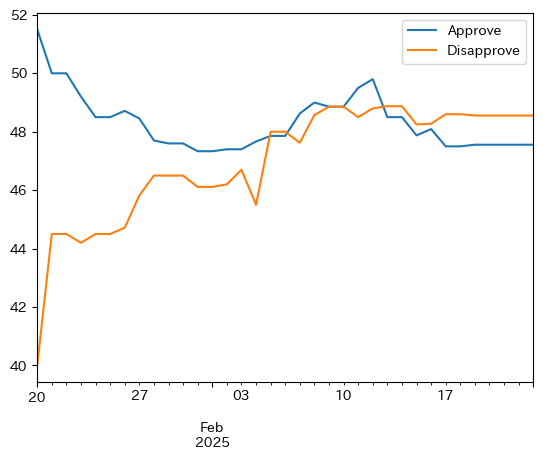

In [12]:

make_graph(df).plot()